# CrossBee workflow demo based on Python Script Modules for LBD Text Mining Analysis

CrossBee is a system that recommends bridging terms (*b-terms*) through an ensemble-based ranking method. It aids experts in uncovering hidden connections between unrelated domains. The user-friendly CrossBee web application facilitates the ranking, exploration, and efficient investigation of these cross-domain links.

Import LBD components from notebooks.

In [1]:
import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

importing Jupyter notebook from LBD_01_data_acquisition.ipynb
importing Jupyter notebook from LBD_02_data_preprocessing.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


importing Jupyter notebook from LBD_03_feature_extraction.ipynb
importing Jupyter notebook from LBD_04_text_mining.ipynb
importing Jupyter notebook from LBD_05_results_analysis.ipynb
importing Jupyter notebook from LBD_06_visualization.ipynb


In [2]:
import nltk
import numpy as np
import itertools
import pandas as pd
# import pickle
# import json
import spacy
from typing import List, Dict

Define domain name and load text from file.

In [ ]:
domainName = 'Migraine-Magnesium'
fileName = 'input/Magnesium_Migraine_before1988.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [4]:
domainName = 'Autism-Calcineurin'
fileName = 'input/Autism_Calcineurin.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

['1: !Autism The basis for the need for improved training and collaboration models in the field of autism is supported through historical background and literature in related fields. Ultimately, training specific to autism spectrum disorders and related evidence-based practices is proposed as necessary for all care providers having influence on programming related to this special population. It is also posited that the most effective avenue for training is through models incorporating more intensive and interactive training processes such as hands-on learning activities with opportunities for coaching, modeling, practice and feedback. Effective collaboration across systems (including home, medical, educational, and community settings) is emphasized to facilitate consistency in implementation of strategies for ultimate program success.\n',
 '2: !Autism Children diagnosed with autism or autism spectrum disorders (ASD) are more likely than other children to exhibit behaviors characteristi

Preprocess documents into a dictionary and extract documents as strings in a list. Might take a few minutes for longer files.

In [5]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = ['autism', 'calcineurin']
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 4, keep_only_nouns = True, keep_only_mesh = False, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)


Display the first dictionary items, document (pubmed) ids and preprocessed documents.

In [6]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'1': {'domain': 'Autism',
  'document': 'The basis for the need for improved training and collaboration models in the field of autism is supported through historical background and literature in related fields. Ultimately, training specific to autism spectrum disorders and related evidence-based practices is proposed as necessary for all care providers having influence on programming related to this special population. It is also posited that the most effective avenue for training is through models incorporating more intensive and interactive training processes such as hands-on learning activities with opportunities for coaching, modeling, practice and feedback. Effective collaboration across systems (including home, medical, educational, and community settings) is emphasized to facilitate consistency in implementation of strategies for ultimate program success.',
  'preprocessed': 'basis train collaboration model field background literature field spectrum disorder practice care provi

In [7]:
prep_docs_list[:7]

['basis train collaboration model field background literature field spectrum disorder practice care providers influence program population avenue train model train process handson activities opportunities coach model practice feedback collaboration systems home community settings consistency implementation strategies program success',
 'children diagnose spectrum disorder children exhibit behaviors feed sleep disorder parent children disorder health safety child sleep feed problems deal stress parent family members assessment treatment procedures address behavior problems sleep feed disorder article review literature assessment treatment recommendations service family members individuals feed sleep disorder',
 'behaviors individuals disabilities behaviors treatment target injury assessment function behaviors step treatment plan article background discussion assessment treatment behaviors readers perspective individuals disabilities',
 'skill deficits feature spectrum disorder skills co

Generate bag-of-words matrix from the list of preprocessed documents. Remove ngram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents.

In [8]:
ngram_size = 1 # 3 for migraine
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3 # 2 for migraine
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        # if word in mesh_word_list:
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all ngrams:  34988
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  34988


Compute margins for bag-of-word matrix. Prepare also the dictionaries of words and documents sorted according to the sum of word count in BOW matrix (*bow_matrix*)

In [9]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'0110micromoll': 1, '021s': 1, '028s': 1, '02min': 1, '05fold': 1, '072individual': 1, '10000s': 1}
Number of occurences of each word in all documents:  {'0110micromoll': 1, '021s': 1, '028s': 1, '02min': 1, '05fold': 1, '072individual': 1, '10000s': 1}
Number of words in each document:  {'1': 38, '2': 46, '3': 23, '4': 38, '5': 33, '6': 27, '7': 31}
The first few documents in the rows of the filtered bow matrix:  ['10387', '3894', '4059', '5073', '59', '2648', '4329']
The first few words in the columns of the filtered bow matrix:  ['children', 'study', 'disorder', 'patients', 'group', 'effect', 'protein']


Visualize bag-of-words matrix.

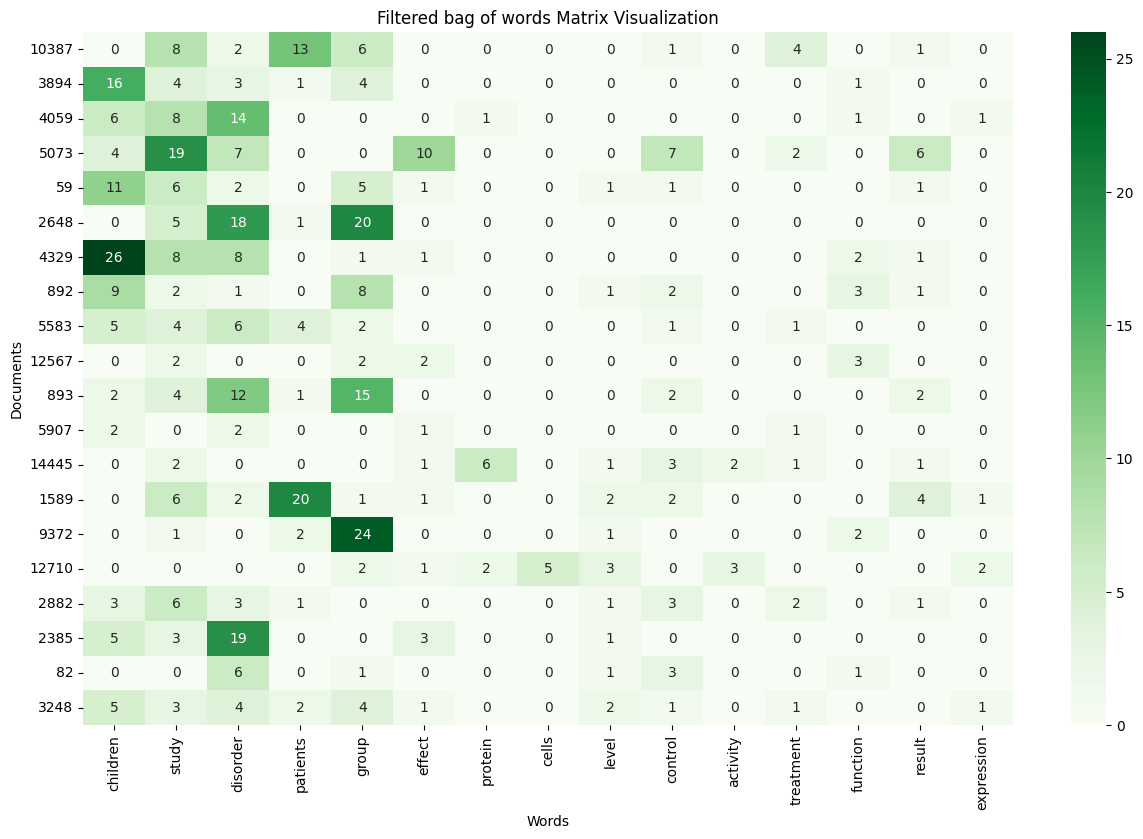

In [10]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [11]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

Number of terms in initial vocabulary with all ngrams:  34988
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  34988


Compute margins for tf-idf matrix.

In [12]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tfidf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tfidf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tfidf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tfidf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tfidf for each word:  {'0110micromoll': 0.20663437281475872, '021s': 0.14648204911486157, '028s': 0.14648204911486157, '02min': 0.05803827767344634, '05fold': 0.13727224186318382, '072individual': 0.11755262764412579, '10000s': 0.18162209713916935}
Max of tfidf for each word:  {'0110micromoll': 0.20663437281475872, '021s': 0.14648204911486157, '028s': 0.14648204911486157, '02min': 0.05803827767344634, '05fold': 0.13727224186318382, '072individual': 0.11755262764412579, '10000s': 0.18162209713916935}
Sum of tfidf for each document:  {'1': 5.012278659871322, '2': 4.205201472113132, '3': 3.5258013482046717, '4': 4.9559190892794485, '5': 4.624036964635491, '6': 3.986601158703161, '7': 3.7299204311581833}
Max of tfidf for each document:  {'1': 0.3578262044726624, '2': 0.5896355585649714, '3': 0.5600874346334463, '4': 0.45035539021654164, '5': 0.3575086480177052, '6': 0.4445410349803252, '7': 0.5382978160766094}


Visualize tf-idf matrix.

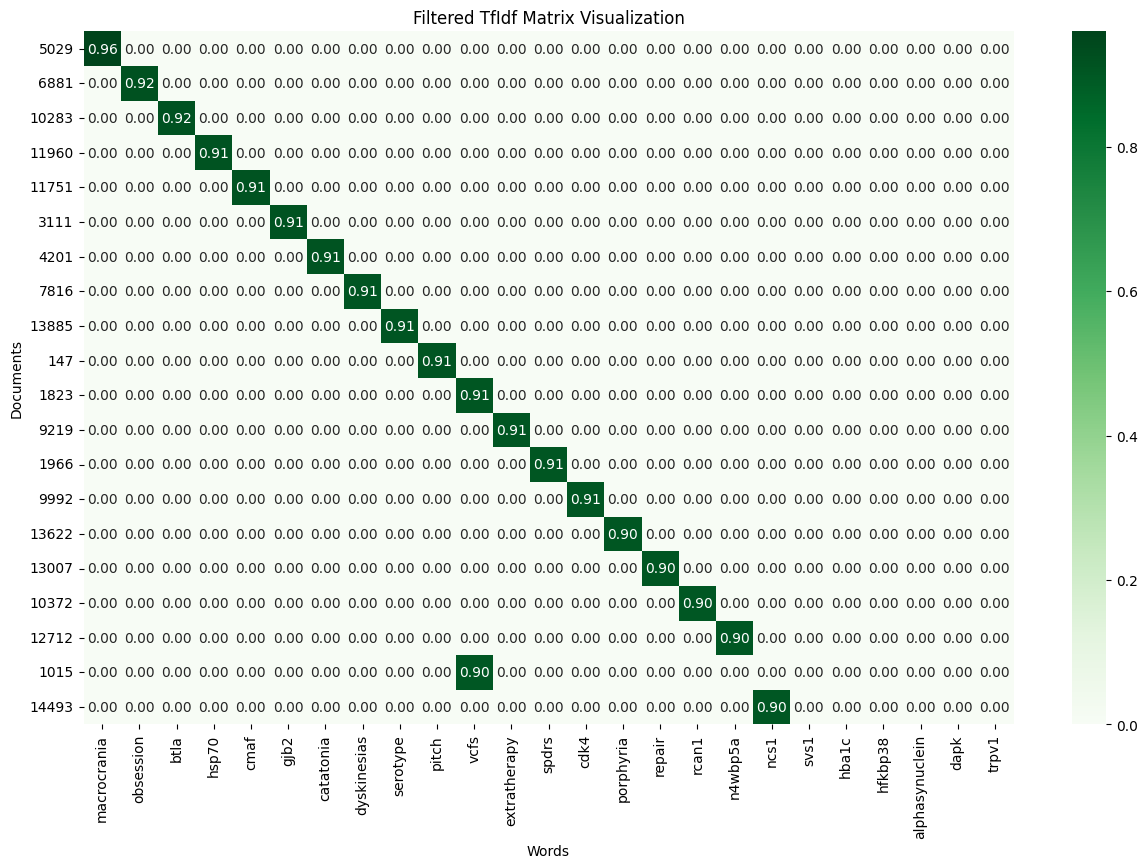

In [13]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [14]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism']
A list of all uniques domain names in all the documents:  ['Autism', 'Calcineurin']


In [15]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
no_documents_in_domain = {}
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    no_documents_in_domain[domain_name] = len(domain_docs_indices)
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)
print(no_documents_in_domain)

[0, 1, 2, 3, 4, 5, 6]
0 [0 0 0 ... 0 0 0]
[9365, 9366, 9367, 9368, 9369, 9370, 9371]
1 [1 1 1 ... 1 6 2]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 6. 2.]]
{'Autism': 9365, 'Calcineurin': 5878}


In [16]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


0.0

In [17]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
sum_word_tfidf_selected = {} ### TODO from her on ...
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 1:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected bterm candidate words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted bterm candidate words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted bterm word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  34988
Selected bterm candidate words:  6122   {'100fold': 0.13306149670273734, '100microm': 0.12995505724903342, '12hr': 0.19273992369468024, '12th': 0.2707772025108404, '145trisphosphate': 0.2407985296583372, '15fold': 0.20987815314047314, '15min': 0.3238751272726699, '17year': 0.11296959270204106, '1950s': 0.25234969099033183, '1960s': 0.23654738448985962, '1970s': 0.33812465058278923, '1980s': 0.35027924627045326, '1990s': 0.3604285172646603, '1year': 0.19884452067656477, '21st': 0.1628179174021525, '22q112': 0.6863245819239601, '24bp': 0.17165283145679794, '24hr': 0.17394998922305338, '28day': 0.16513236533971237, '30min': 0.35618019905711323, '3day': 0.1988803080269417, '46fold': 0.12537381450961604, '4ebp1': 0.2152459993199779, '6month': 0.2392101450168585, '72hr': 0.15266798211419919, '7day': 0.2112757913052895, '95ci': 0.145171200560478, 'abandonment': 0.20143020919520216, 'abbreviate': 0.35473973079532617

In [18]:
bterms_list = list(max_word_tfidf_selected_sorted.keys())
bterms_list_length = len(bterms_list)

df = pd.DataFrame({'b-term': bterms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

,b-term,max tfidf
0,vcfs,0.906327
1,repair,0.903787
2,psoriasis,0.888768
3,trail,0.885305
4,caregivers,0.879413
5,aldosterone,0.878232
6,instruction,0.874098
7,bcl2,0.871731
8,s100b,0.871627
9,ghrh,0.871276


In [23]:
name = 'bcl2'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

bcl2: position in the list of rare terms 7 (6122), max tfidf: 0.872


In [24]:
petric_bterms = ["22q112", "deletion syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "synaptic plasticity", "type 1 diabetes", \
                 "ulcerative colitis", "working memory", \
                 "t17p22q21"]

petric_bterms = ["22q112", "deletion", "syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "plasticity", "diabetes", \
                 "colitis", "work", "memory", "t17p22q21"]
nn = 0
indb = []
size = len(max_word_tfidf_selected_sorted)
for name in petric_bterms:
    if name in max_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(max_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of potential bterms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
             '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(petric_bterms))
print(indb)

22q112: position in the list of potential bterms 355 (6122), max tfidf: 0.686 part: 5.8
deletion: position in the list of potential bterms 271 (6122), max tfidf: 0.711 part: 4.4
syndrome: position in the list of potential bterms 57 (6122), max tfidf: 0.817 part: 0.9
asbestos: position in the list of potential bterms 219 (6122), max tfidf: 0.729 part: 3.6
bcl2: position in the list of potential bterms 7 (6122), max tfidf: 0.872 part: 0.1
bombesin: position in the list of potential bterms 3798 (6122), max tfidf: 0.278 part: 62.0
calmodulin: position in the list of potential bterms 369 (6122), max tfidf: 0.680 part: 6.0
radiation: position in the list of potential bterms 994 (6122), max tfidf: 0.553 part: 16.2
hypothyroxinemia: position in the list of potential bterms 5622 (6122), max tfidf: 0.171 part: 91.8
synaptic: position in the list of potential bterms 448 (6122), max tfidf: 0.660 part: 7.3
plasticity: position in the list of potential bterms 470 (6122), max tfidf: 0.657 part: 7.7
d

Missing and changed b-terms:

- maternal hypothyroxinemia -> hypothyroxinemia
- ulcerative colitis -> colitis
- t17p22q21 - found only in Autism documents

TODO: implement selected heuristics for bterm ranking

In [25]:
pt = []
for i in range(size):
    pt.append(0)
for i in range(len(indb)):
    for j in range(indb[i], size):
        pt[j] += 1
print(pt)
suma = 0
part = 0
for i in range(size):
    print((i+1)/size*100.0, pt[i]/len(indb)*100.0)
    part += pt[i]
    suma += len(indb)
print(part/suma*100.0)

no_all_bterm_candidates = size
no_swansons_bterms = len(indb)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

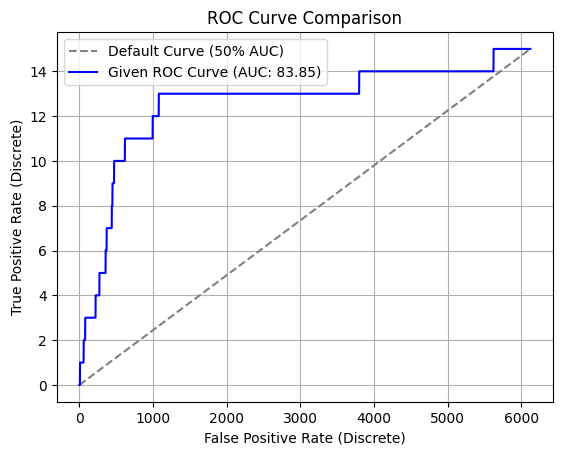

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example ROC curve points (y-values), replace with the actual list of 120 numbers
roc_points = pt

# X-values for the ROC curve (0 to 120)
x_values = np.arange(0, no_all_bterm_candidates)

# Calculating the AUC for the given ROC curve using the trapezoidal rule
auc = np.trapz(roc_points, x_values) / (no_all_bterm_candidates*no_swansons_bterms) * 100  # Normalizing by the area of the full plot

# Plotting the default curve (50% AUC)
default_x = np.array([0, no_all_bterm_candidates])
default_y = np.array([0, no_swansons_bterms])
plt.plot(default_x, default_y, label='Default Curve (50% AUC)', linestyle='--', color='gray')

# Plotting the given ROC curve
plt.plot(x_values, roc_points, label=f'Given ROC Curve (AUC: {auc:.2f})', color='blue')

# Adding labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (Discrete)')
plt.ylabel('True Positive Rate (Discrete)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()